# Laboratorio No. 2 - Data Science

Manuel Rodas - 21509 / Sebastián Solorzano - 21826

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

### Carga de datos

In [2]:
def limpiar_datos(df):
    for col in df.columns[1:]:
        df[col] = df[col].str.replace(' ', '', regex=True)
        df[col] = df[col].str.replace(',', '.', regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [3]:
consumos_df = pd.read_csv('consumo.csv', sep=';', encoding='utf-8')
consumos_df = consumos_df.dropna(axis=1, how='all')
consumos_df = consumos_df[['Fecha', 'Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petr�leo']]
consumos_df = limpiar_datos(consumos_df)
consumos_df.head()

,Fecha,Gasolina regular,Gasolina superior,Diesel bajo azufre,Gas licuado de petr�leo
0,ene/2000,202645.20,308156.82,0.0,194410.48
1,feb/2000,205530.96,307766.31,0.0,174710.55
2,mar/2000,229499.56,331910.29,0.0,189234.07
3,abr/2000,210680.40,315648.08,0.0,174330.61
4,may/2000,208164.34,319667.97,0.0,191745.15


In [4]:
importaciones_df1 = pd.read_csv('importacion.csv', sep=';', encoding='utf-8')
importaciones_df1 = importaciones_df1.dropna(axis=1, how='all')
importaciones_df1 = importaciones_df1[['Fecha', 'Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petr�leo']]
importaciones_df1 = limpiar_datos(importaciones_df1)
importaciones_df1.head()

,Fecha,Gasolina regular,Gasolina superior,Diesel bajo azufre,Gas licuado de petr�leo
0,ene/2001,177776.50,373963.96,0.0,194065.74
1,feb/2001,123115.99,243091.07,0.0,170703.38
2,mar/2001,161726.42,312084.38,0.0,161837.37
3,abr/2001,127338.74,285054.89,0.0,163048.64
4,may/2001,168730.19,300913.67,0.0,171518.86


In [5]:
precios2024_df = pd.read_csv('precios2024.csv', sep=';', encoding='utf-8')
precios2024_df = precios2024_df.dropna(axis=1, how='all')

precios2023_df = pd.read_csv('precios2023.csv', sep=';', encoding='utf-8')
precios2023_df = precios2023_df.dropna(axis=1, how='all')

precios2022_df = pd.read_csv('precios2022.csv', sep=';', encoding='utf-8')
precios2022_df = precios2022_df.dropna(axis=1, how='all')

precios2021_df = pd.read_csv('precios2021.csv', sep=';', encoding='utf-8')
precios2021_df = precios2021_df.dropna(axis=1, how='all')

precios_df = pd.concat([precios2021_df, precios2022_df, precios2023_df, precios2024_df])
precios_df = precios_df[['FECHA', 'Superior', 'Regular', 'Diesel', 'Glp Cilindro 25Lbs.']]
precios_df.columns = ['Fecha', 'Gasolina superior', 'Gasolina regular', 'Diesel', 'Gas licuado de petróleo']
precios_df = limpiar_datos(precios_df)
precios_df.head()


,Fecha,Gasolina superior,Gasolina regular,Diesel,Gas licuado de petróleo
0,01/ene/2021,21.91,21.11,17.61,99.0
1,02/ene/2021,21.91,21.11,17.61,99.0
2,03/ene/2021,21.91,21.11,17.61,99.0
3,04/ene/2021,21.91,21.11,17.61,99.0
4,05/ene/2021,21.91,21.11,17.61,99.0


### Análisis exploratorio

In [6]:
def verificar_normalidad(df):
    resultados = {}
    for col in df.columns[1:]:
        stat, p_value = shapiro(df[col].dropna())
        resultados[col] = p_value
    return resultados

In [7]:
def graficar_datos(consumos_df, importaciones_df1, precios_df):
    plt.figure(figsize=(14, 10))
    
    # Graficar datos de consumo
    plt.subplot(3, 1, 1)
    consumos_df[['Fecha', 'Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petr�leo']].set_index('Fecha').plot(kind='line', ax=plt.gca())
    plt.title('Consumo de Combustibles')
    plt.xticks(rotation=45)
    
    # Graficar datos de importación
    plt.subplot(3, 1, 2)
    importaciones_df1[['Fecha', 'Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petr�leo']].set_index('Fecha').plot(kind='line', ax=plt.gca())
    plt.title('Importaciones de Combustibles')
    plt.xticks(rotation=45)
    
    # Graficar datos de precios
    plt.subplot(3, 1, 3)
    precios_df[['Fecha', 'Gasolina superior', 'Gasolina regular', 'Diesel', 'Gas licuado de petróleo']].set_index('Fecha').plot(kind='line', ax=plt.gca())
    plt.title('Precios de Combustibles')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analizar_picos(importaciones_df1):    
    importaciones_df2 = importaciones_df1.copy()

    # Convertir la columna 'Fecha' a datetime y establecerla como índice
    importaciones_df2['Fecha'] = pd.to_datetime(importaciones_df2['Fecha'], format='%b/%Y', errors='coerce')
    
    # Verificar si la conversión de fechas fue exitosa
    if importaciones_df2['Fecha'].isnull().all():
        print("Error: No se pudieron convertir las fechas. Verifique el formato de las fechas en el CSV.")
        return
    
    importaciones_df2.set_index('Fecha', inplace=True)
    
    # Agrupar datos por mes manualmente
    importaciones_mensuales = importaciones_df2[['Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petr�leo']].resample('M').sum()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=importaciones_mensuales)
    plt.title('Importaciones Mensuales de Combustibles')
    plt.xlabel('Fecha')
    plt.ylabel('Volumen')
    plt.xticks(rotation=45, ha='right')
    plt.show()
        
    # Filtrar por período de pandemia
    importaciones_pandemia = importaciones_mensuales.loc['2020-03':'2022-12']
    
    # Verificar si hay datos durante la pandemia
    if importaciones_pandemia.empty:
        print("No hay datos disponibles para el período de la pandemia.")
    else:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=importaciones_pandemia)
        plt.title('Importaciones durante la Pandemia')
        plt.xlabel('Fecha')
        plt.ylabel('Volumen')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()  # Ajustar el diseño para que no se corten etiquetas
        plt.show()

In [9]:
normalidad_consumo = verificar_normalidad(consumos_df)
normalidad_importacion = verificar_normalidad(importaciones_df1)
normalidad_precios = verificar_normalidad(precios_df)

print("Normalidad en datos de consumo:", normalidad_consumo)
print("Normalidad en datos de importación:", normalidad_importacion)
print("Normalidad en datos de precios:", normalidad_precios)

Normalidad en datos de consumo: {'Gasolina regular': 1.3333423045052765e-16, 'Gasolina superior': 3.3319368373273852e-12, 'Diesel bajo azufre': 9.332616072193326e-26, 'Gas licuado de petr�leo': 3.1577836482406835e-14}
Normalidad en datos de importación: {'Gasolina regular': 1.8343557582560277e-12, 'Gasolina superior': 2.6268341703425063e-05, 'Diesel bajo azufre': 1.1129243537452424e-24, 'Gas licuado de petr�leo': 1.985218327462084e-07}
Normalidad en datos de precios: {'Gasolina superior': 1.8635733529599887e-07, 'Gasolina regular': 8.969604447466781e-08, 'Diesel': 4.248561947101779e-09, 'Gas licuado de petróleo': 9.387398781364746e-29}


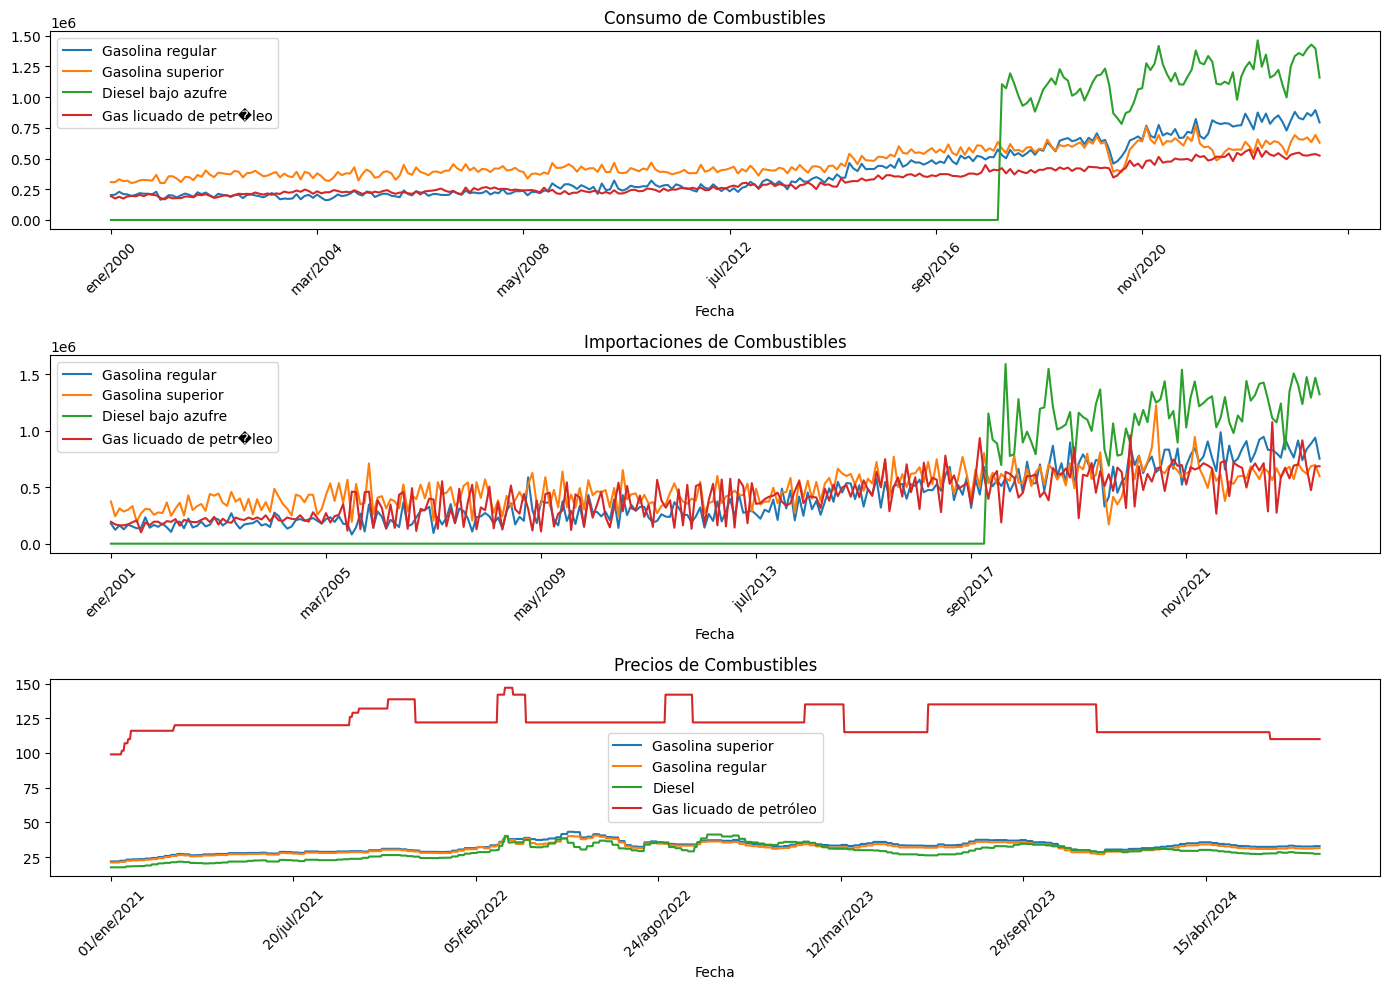

In [10]:
graficar_datos(consumos_df, importaciones_df1, precios_df)

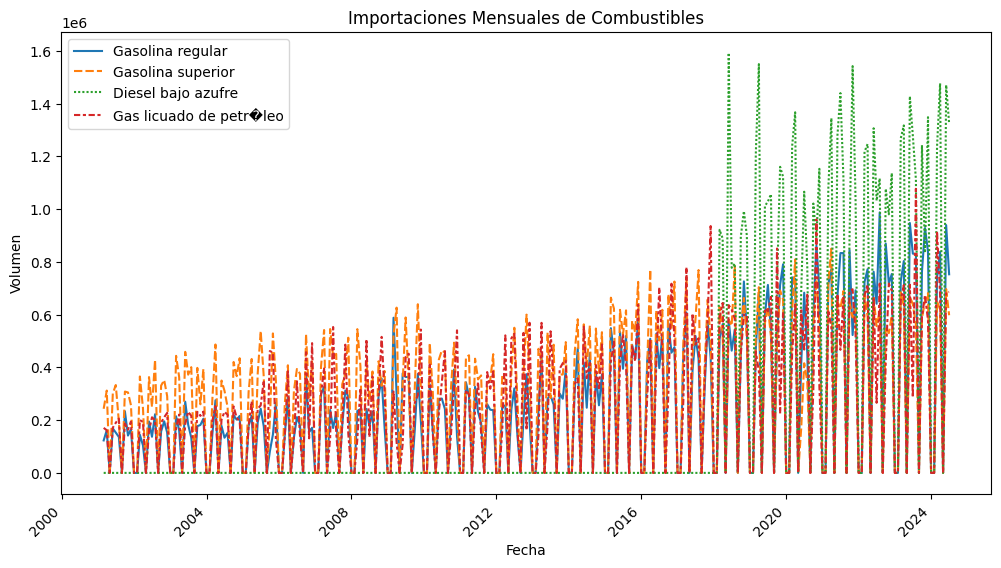

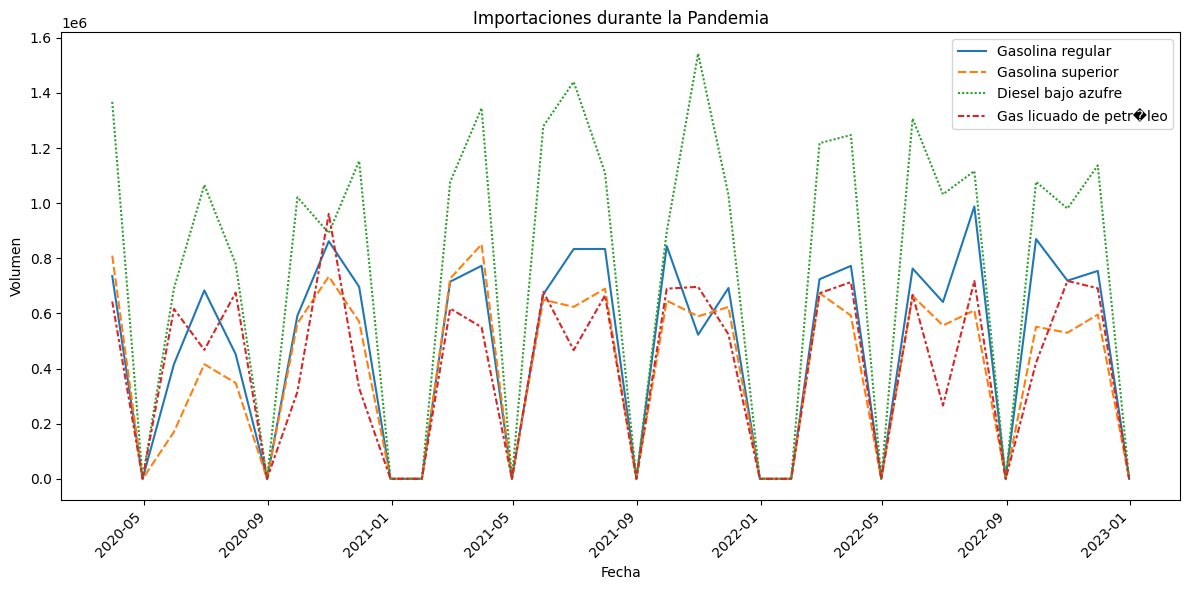

In [11]:
analizar_picos(importaciones_df1)

### Serie de consumos

In [12]:
consumos_df2 = consumos_df.copy()
# Convertir la columna 'Fecha' a datetime y establecerla como índice
consumos_df2['Fecha'] = pd.to_datetime(consumos_df2['Fecha'], format='%b/%Y', errors='coerce')

# Verificar si la conversión de fechas fue exitosa
if consumos_df2['Fecha'].isnull().all():
    print("Error: No se pudieron convertir las fechas. Verifique el formato de las fechas en el CSV.")

consumos_df2.set_index('Fecha', inplace=True)

In [13]:
# Inicio, fin y frecuencia de los datos
print("Inicio de los datos:", consumos_df2.index.min())
print("Fin de los datos:", consumos_df2.index.max())
print("Frecuencia de los datos:", consumos_df2.index.to_series().diff().value_counts())

Inicio de los datos: 2000-02-01 00:00:00
Fin de los datos: 2024-06-01 00:00:00
Frecuencia de los datos: Fecha
31 days    49
30 days    48
28 days    18
29 days     7
Name: count, dtype: int64


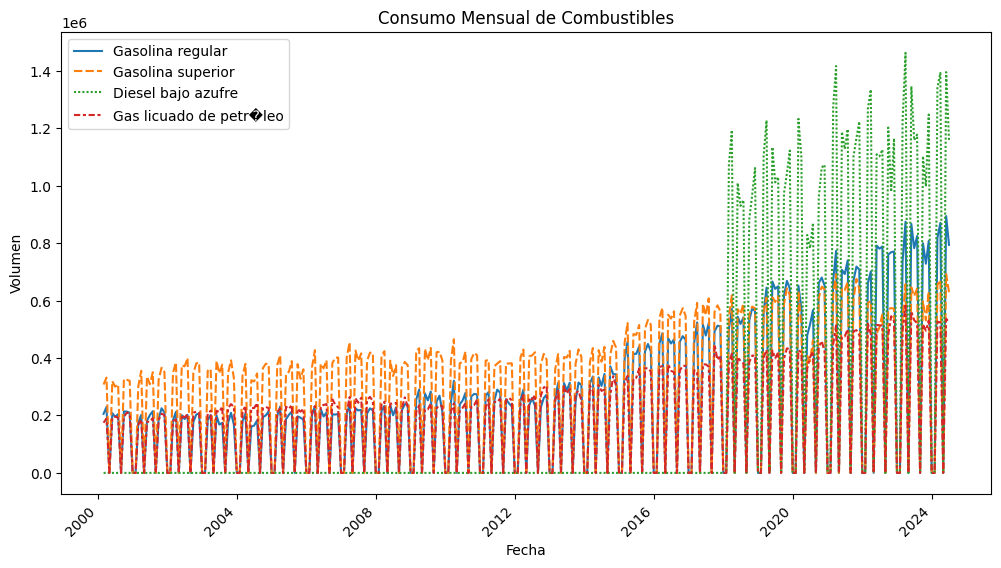

In [14]:
# Gráfico de la Serie consumos
plt.figure(figsize=(12, 6))
sns.lineplot(data=consumos_df2.resample('M').sum())
plt.title('Consumo Mensual de Combustibles')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45, ha='right')
plt.show()

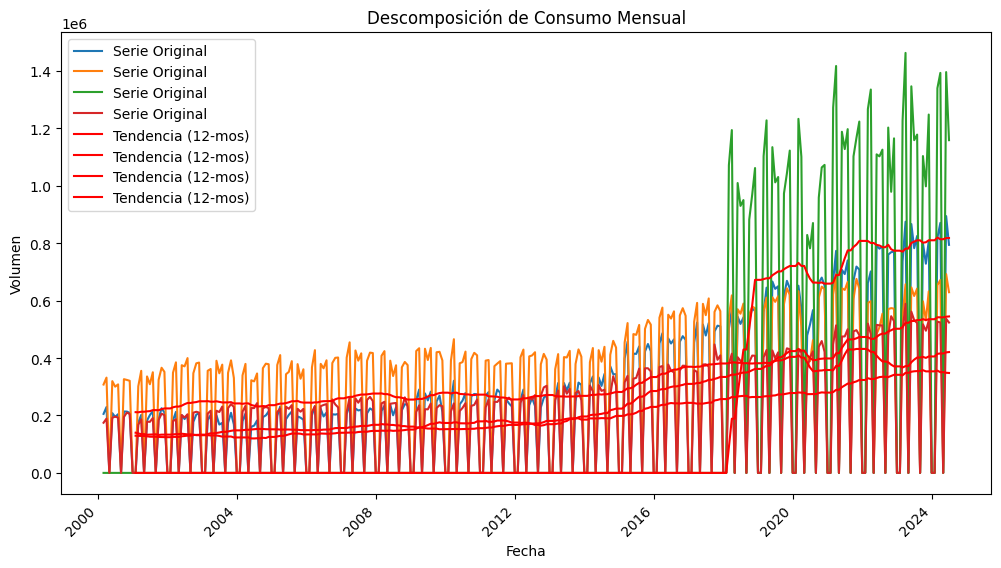

In [16]:
# Descomposición de la Serie
consumo_mensual = consumos_df2.resample('M').sum()
consumo_mensual_decomp = consumo_mensual.rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(consumo_mensual, label='Serie Original')
plt.plot(consumo_mensual_decomp, label='Tendencia (12-mos)', color='red')
plt.legend()
plt.title('Descomposición de Consumo Mensual')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45, ha='right')
plt.show()

In [18]:
# Transformación de la Serie
consumo_mensual_log = np.log(consumo_mensual.replace(0, np.nan))

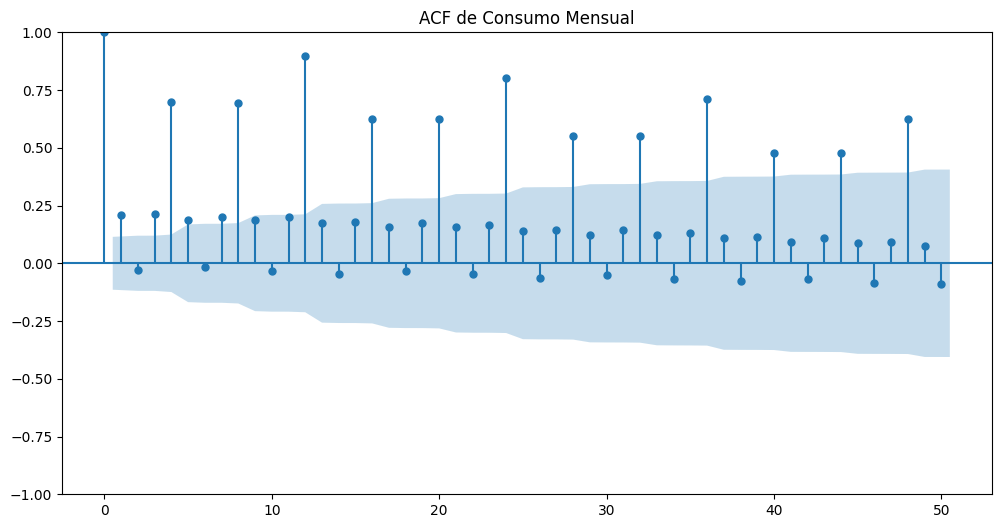

Estadístico ADF: 1.7800966484477188
Valor p: 0.9983087141941656


In [21]:
# Estacionariedad en Media
consumo_mensual_columna = consumo_mensual['Gasolina regular']

# Gráfico de ACF
plt.figure(figsize=(12, 6))
plot_acf(consumo_mensual_columna.dropna(), lags=50, ax=plt.gca())
plt.title('ACF de Consumo Mensual')
plt.show()

# Prueba de Estacionariedad ADF
adf_result = adfuller(consumo_mensual_columna.dropna())
print(f'Estadístico ADF: {adf_result[0]}')
print(f'Valor p: {adf_result[1]}')

In [25]:
# Estacionariedad en Media
consumo_mensual_columna = consumo_mensual['Gasolina regular'].dropna()

# Parámetros del Modelo ARIMA
auto_model = auto_arima(consumo_mensual_columna, seasonal=True, m=12)
print(auto_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  293
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -3343.207
Date:                                 Sun, 18 Aug 2024   AIC                           6696.413
Time:                                         18:47:52   BIC                           6714.587
Sample:                                     02-29-2000   HQIC                          6703.703
                                          - 06-30-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6511      0.046    -14.063      0.000      -0.742      -0

c:\Users\50242\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\50242\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\50242\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


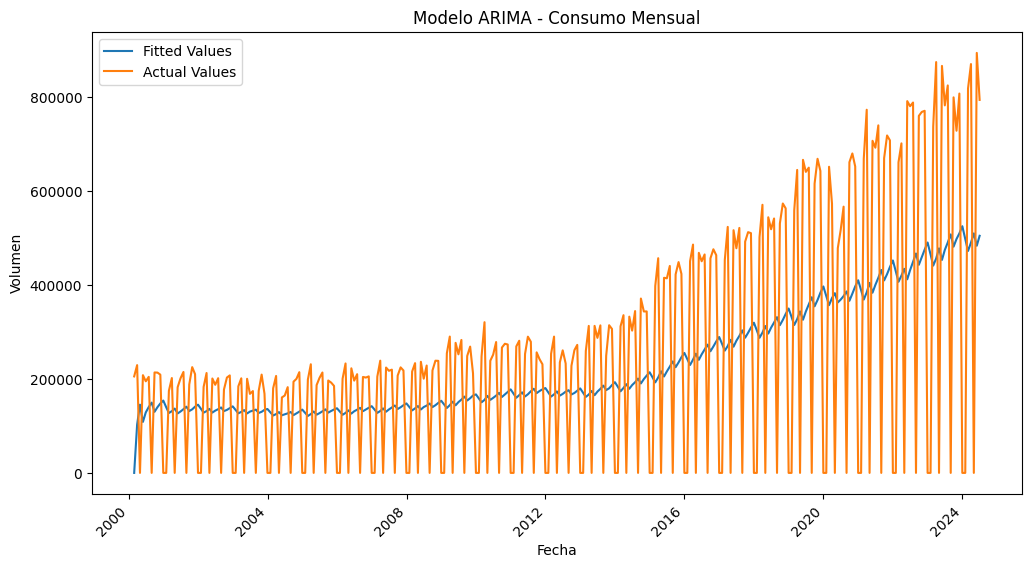

AIC: 8004.2573022507595
BIC: 8011.610809855296


In [28]:
# Estacionariedad en Media
consumo_mensual_columna = consumo_mensual['Gasolina regular'].dropna()

# Modelos ARIMA
best_model = ARIMA(consumo_mensual_columna, order=auto_model.order)
best_fit = best_model.fit()

plt.figure(figsize=(12, 6))
plt.plot(best_fit.fittedvalues, label='Fitted Values')
plt.plot(consumo_mensual_columna, label='Actual Values')
plt.legend()
plt.title('Modelo ARIMA - Consumo Mensual')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45, ha='right')
plt.show()

print(f'AIC: {best_fit.aic}')
print(f'BIC: {best_fit.bic}')

19:01:39 - cmdstanpy - INFO - Chain [1] start processing
19:01:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\50242\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\50242\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


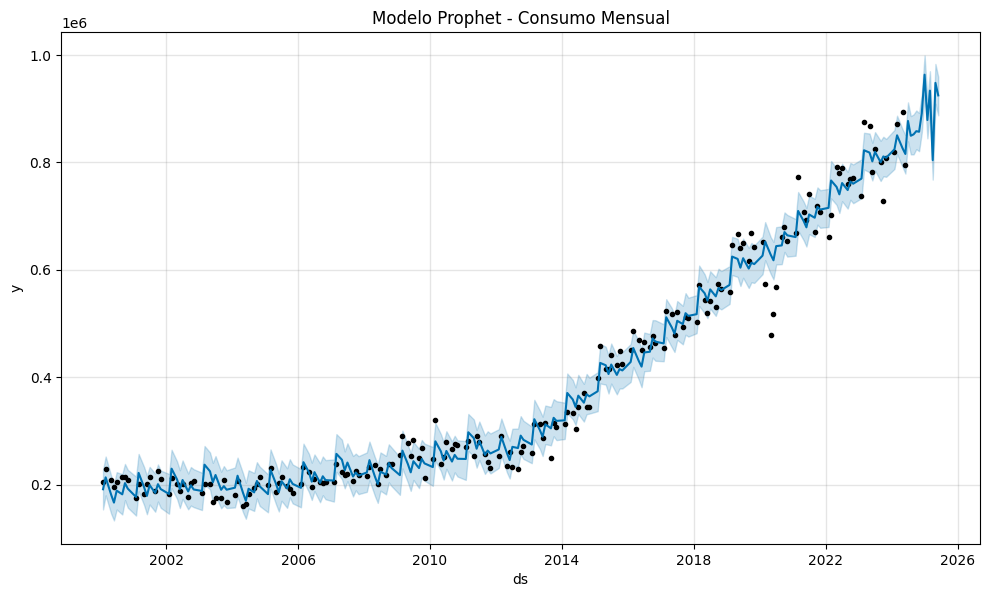

In [37]:
# Crear el DataFrame para Prophet
consumo_df_prophet = consumos_df[['Fecha', 'Gasolina regular']].copy()
consumo_df_prophet['Fecha'] = pd.to_datetime(consumo_df_prophet['Fecha'], format='%b/%Y', errors='coerce')
consumo_df_prophet = consumo_df_prophet.dropna(subset=['Fecha'])  # Eliminar filas con fechas inválidas
consumo_df_prophet = consumo_df_prophet.rename(columns={'Fecha': 'ds', 'Gasolina regular': 'y'})
consumo_df_prophet = consumo_df_prophet.dropna(subset=['y'])  # Eliminar filas con valores 'y' NaN

# Modelo Prophet
prophet_model = Prophet()
prophet_model.fit(consumo_df_prophet)

# DataFrame para el futuro
future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

# Gráfico del pronóstico
fig = prophet_model.plot(forecast)
plt.title('Modelo Prophet - Consumo Mensual')
plt.show()